In [1]:
import xml.etree.ElementTree as et
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser  = English()

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score

import gensim
from gensim import corpora
from gensim.models import TfidfModel
from gensim import matutils
from gensim.models import CoherenceModel

from operator import itemgetter

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Evan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from absa_functions import *

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', -1)

<ipython-input-3-3309e384d275>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [4]:
train_path = 'test.xml'
corpus_df, categories = create_corpus(train_path)

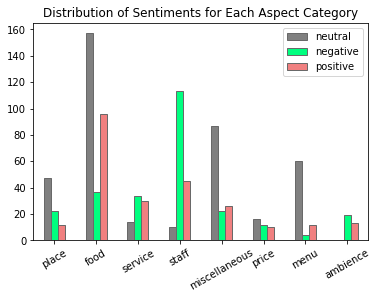

In [5]:
counts = {}
for cat in categories:
    counts.update({cat: dict(corpus_df[f'{cat}'].value_counts())})

count_df = pd.DataFrame(counts).transpose()

count_df.plot(kind = 'bar', color = ['grey', 'springgreen', 'lightcoral'], edgecolor = 'dimgrey')
plt.xticks(rotation = 30);
plt.title('Distribution of Sentiments for Each Aspect Category');

In [6]:
#download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Evan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
text_data = preprocess_corpus(corpus_df)

In [8]:
dictionary, corpus = create_bagofwords(text_data)

In [9]:
lda_model = gensim.models.ldamodel.LdaModel.load('best_lda_model.gensim')

In [10]:
topic_match_df = apply_lda_to_corpus(lda_model, corpus, corpus_df, categories)
topic_match_df.head()

,place,food,service,staff,miscellaneous,price,menu,ambience,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054403,0.060526,0.452378,0.412222,0.000000,0.000000,0.000000
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.020547,0.203474,0.020432,0.020423,0.544866,0.169721,0.020536
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.020413,0.020420,0.020411,0.020433,0.481967,0.020442,0.415913
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.012997,0.619380,0.193567,0.134668,0.013037,0.013189,0.013162
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.014289,0.173171,0.014290,0.014378,0.447117,0.014309,0.322446


Text(0.5, 1.0, 'Correlation Between Latent Topics and Topic Labels')

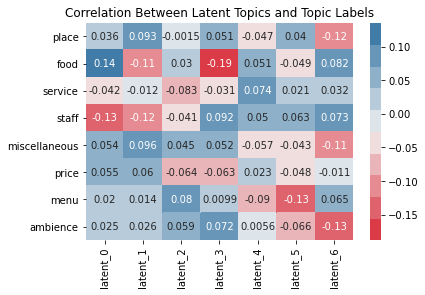

In [11]:
topic_corr = topic_match_df.corr()[[f'latent_{i}' for i in range(0,len(categories) - 1)]][0:len(categories)]

sns.heatmap(topic_corr, annot=True, cmap=sns.diverging_palette(10 ,240, n=10))
plt.title('Correlation Between Latent Topics and Topic Labels')

In [12]:
#numerical mapping for topics in LDA model
topic_map = {0: 'menu', 1: 'service', 2: 'miscellaneous', 3: 'place', 4: 'price', 5: 'food', 6: 'staff'}

In [13]:
lda_df = compile_strong_topics(lda_model, corpus, corpus_df, topic_map)
lda_df.head()

,text,lda_topic
0,"We went again and sat at the bar this time, I had 5 pints of guinness and not one buy-back, I ordered a basket of onion rings and there were about 5 in the basket, the rest was filled with crumbs, the chili was not even edible.","{'price': 0.45244017, 'staff': 0.41215947}"
1,"The food was good, but it's not worth the wait--or the lousy service.","{'price': 0.5449679, 'service': 0.2033738}"
2,Waiter took our drink order and then we didn't see him for 15 minutes.,"{'price': 0.48184633, 'staff': 0.41603398}"
3,"It does get crowded with plenty of blue shirted cigar smoking wannabes, so make a reservation.","{'service': 0.6193761, 'miscellaneous': 0.1935654}"
4,"After hearing all of the specials, you would think they were twice as much as the menu prices (as other places do).","{'price': 0.44713697, 'staff': 0.32242122}"


In [14]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Evan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [15]:
lda_df = sentiment_analysis(lda_df, categories)
lda_df.head()

,text,lda_topic,vader_score,compound_score,sentiment,place,food,service,staff,miscellaneous,price,menu,ambience
0,"We went again and sat at the bar this time, I had 5 pints of guinness and not one buy-back, I ordered a basket of onion rings and there were about 5 in the basket, the rest was filled with crumbs, the chili was not even edible.","{'price': 0.45244017, 'staff': 0.41215947}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral,NaN,NaN,NaN,neutral,NaN,neutral,NaN,None
1,"The food was good, but it's not worth the wait--or the lousy service.","{'price': 0.5449679, 'service': 0.2033738}","{'neg': 0.361, 'neu': 0.535, 'pos': 0.104, 'compound': -0.7003}",-0.7003,negative,NaN,NaN,negative,NaN,NaN,negative,NaN,None
2,Waiter took our drink order and then we didn't see him for 15 minutes.,"{'price': 0.48184633, 'staff': 0.41603398}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral,NaN,NaN,NaN,neutral,NaN,neutral,NaN,None
3,"It does get crowded with plenty of blue shirted cigar smoking wannabes, so make a reservation.","{'service': 0.6193761, 'miscellaneous': 0.1935654}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral,NaN,NaN,neutral,NaN,neutral,NaN,NaN,None
4,"After hearing all of the specials, you would think they were twice as much as the menu prices (as other places do).","{'price': 0.44713697, 'staff': 0.32242122}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,neutral,NaN,NaN,NaN,neutral,NaN,neutral,NaN,None


In [16]:
pred_cats_df = create_label_df(corpus_df, categories)
true_cats_df = create_label_df(lda_df, categories)

accuracy = calculate_accuracy(pred_cats_df, true_cats_df)
print(accuracy)

55.51378446115287


In [17]:
pred_cats_enum_df = add_label_col(pred_cats_df, categories)
true_cats_enum_df = add_label_col(true_cats_df, categories)

precision, recall, f1 = calculate_scores(pred_cats_enum_df, true_cats_enum_df)

print(f'Precision: {precision}\nRecall: {recall}\nF1: {f1}')

Precision: 0.7640608573573425
Recall: 0.9160401002506265
F1: 0.8029383805740737
